In [14]:
#!/usr/bin/env python
#
# Simple DMRG tutorial.  This code contains a basic implementation of the
# infinite system algorithm
#
# Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license.  Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>

# This code will run under any version of Python >= 2.6.  The following line
# provides consistency between python2 and python3.
from __future__ import print_function, division  # requires Python >= 2.6

# numpy and scipy imports
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
from scipy.linalg import eigh
from scipy.linalg import logm
# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple
import matplotlib.pyplot as plt

In [15]:
#system block
SysBlock = namedtuple("SysBlock", ["length", "basis_size", "operator_dict"])
EnlargedsysBlock = namedtuple("EnlargedsysBlock", ["length", "basis_size", "operator_dict"])

#env block
EnvBlock = namedtuple("EnvBlock", ["length", "basis_size", "operator_dict"])
EnlargedenvBlock = namedtuple("EnlargedenvBlock", ["length", "basis_size", "operator_dict"])

In [16]:
# Model-specific code for the Heisenberg XXZ chain
model_d = 2  # single-site basis size

Sz1 = 2*np.array([[0.5, 0], [0, -0.5]], dtype='d')  # single-site S^z
Sx1 = 2*np.array([[0, 0.5], [0.5, 0]], dtype='d')  # single-site S^x


In [17]:
def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

In [18]:
def enlarge_sysblock(J,h,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) +h*kron(identity(mblock),Sx1)+J*kron(o["conn_Sz"],Sz1),
        "Magz":kron(o["Magz"], identity(model_d)) + kron(identity(mblock),Sz1),
        "Magx":kron(o["Magx"], identity(model_d)) + kron(identity(mblock),Sx1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sx": kron(identity(mblock), Sx1),
    }

    return EnlargedsysBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [19]:
def enlarge_envblock(J,h,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        #"H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(np.size(o["conn_Sx"],0)))+J*kron(Sz1,o["conn_Sz"]),
        "H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(mblock))+J*kron(Sz1,o["conn_Sz"]),
        "Magz":kron(identity(model_d),o["Magz"]) + kron(Sz1,identity(mblock)),
        "Magx":kron(identity(model_d),o["Magx"]) + kron(Sx1,identity(mblock)),
        #"H": kron(identity(model_d),o["H"]) - h*kron(identity(model_d),o["conn_Sx"])-J*kron(o["conn_Sz"],Sz1),
        "conn_Sz": kron(Sz1,identity(mblock)),
        "conn_Sx": kron(Sx1,identity(mblock)),
    }

    return EnlargedenvBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [20]:
def single_dmrg_step(J,h,sys, env, m):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    #assert is_valid_block(sys)
    #assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_sysblock(J,h,sys)
    env_enl = enlarge_envblock(J,h,env)
    
#     if sys is env:  # no need to recalculate a second time
#         env_enl = sys_enl
#     else:
#         env_enl = enlarge_block(env)

#     assert is_valid_enlarged_block(sys_enl)
#     assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) \
                             +J*kron(sys_enl_op["conn_Sz"], env_enl_op["conn_Sz"])
    superblock_magz = kron(sys_enl_op["Magz"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["Magz"])
    superblock_magx = kron(sys_enl_op["Magx"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["Magx"])
    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    v = np.ones(sys_enl.basis_size*env_enl.basis_size)
    energy, psi0 = eigsh(superblock_hamiltonian, k=1, which="SA", v0=v)
    expect_magz = psi0.T@superblock_magz@psi0
    expect_magx = psi0.T@superblock_magx@psi0
    psi1=psi0
    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())
    ent_s = -np.trace(rho@logm(rho))
    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = eigh(rho)

    #Build the transformation matrix from the `m` overall most significant
    #eigenvectors.
    my_m = min(sys_enl.basis_size,m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i in range(my_m):
        transformation_matrix[:,i] = evecs[:,sys_enl.basis_size-i-1]
    
    truncation_error = sum([eig1 for eig1 in evals[0:sys_enl.basis_size-m]])
    #print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)
    newblock = SysBlock(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)    
    return newblock, energy, expect_magz, expect_magx,psi1

In [21]:
def infinite_system_algorithm(J,h,L, m):
    H1 = h*Sx1 + 1e-8*Sz1
    Magz1 = Sz1
    Magx1 = Sx1
    initial_block = SysBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        })
    block = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        #print("L =", block.length * 2 + 2)
        block, energy, expect_magz, expect_magx,psi1= single_dmrg_step(J,h,block, block, m=m)
    #print("E/L =", energy / (block.length * 2))
    #print("Magz/L =", expect_magz / (block.length * 2))
    #print("Magx/L =", expect_magx / (block.length * 2))
    #print("L =", block.length * 2)
    EXP_MAGZ = expect_magz / (block.length * 2)
    EXP_MAGX = expect_magx / (block.length * 2)
    return energy, EXP_MAGZ,EXP_MAGX, psi1

In [9]:
np.abs(ppsi0.T@psi0)

NameError: name 'ppsi0' is not defined

In [45]:
ppsi0.T

array([[-2.03083519e-16,  2.45154904e-17,  1.38335955e-15, ...,
        -1.64290741e-18, -8.57501314e-17,  4.18477287e-17],
       [ 4.71280397e-16, -3.33276121e-16,  1.28668459e-08, ...,
         5.55937594e-17, -1.38078356e-16,  6.12854471e-17],
       [-2.24137959e-16,  1.45796830e-16,  2.51460972e-17, ...,
         2.41428806e-17, -5.36025397e-17,  1.67462845e-17],
       ...,
       [ 8.77695221e-17, -4.27382278e-16, -6.68747020e-17, ...,
        -9.95636204e-18,  1.34179069e-17, -3.29276387e-17],
       [ 1.67817045e-17, -6.65820130e-17,  7.34830911e-17, ...,
        -2.39423313e-17,  5.12958846e-17,  4.55630669e-18],
       [-1.14247936e-17,  2.29528880e-16,  1.12863983e-16, ...,
        -7.31038782e-18,  7.26146159e-18, -1.29989017e-17]])

In [32]:
disc_point = 50
h_arr = np.linspace(0,2,disc_point)
fd_arr = np.linspace(0,2,disc_point)
magz_arr = np.linspace(0,2,disc_point)
magx_arr = np.linspace(0,2,disc_point)
ent_s_arr = np.linspace(0,2,disc_point)
for i in range(disc_point):
    energy, EXP_MAGZ,EXP_MAGX,psi1 = infinite_system_algorithm(J = -1,h=h_arr[i],L=6, m=3000)
    energy, EXP_MAGZ,EXP_MAGX,ppsi1 = infinite_system_algorithm(J = -1,h=h_arr[i]-0.001,L=6, m=3000)
    magz_arr[i] =  EXP_MAGZ[0]
    magx_arr[i] =  EXP_MAGX[0]
    #ent_s_arr[i] = ent_s
    fd_arr[i] = np.abs(ppsi1.T@psi1)
    #print("Magz =", EXP_MAGZ[0])
    #print("Magx =", EXP_MAGX[0])

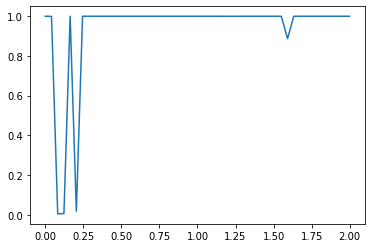

In [34]:
plt.plot(h_arr,abs(fd_arr))

Text(0.5, 0.98, 'Infinite DMRG Phase Diagram')

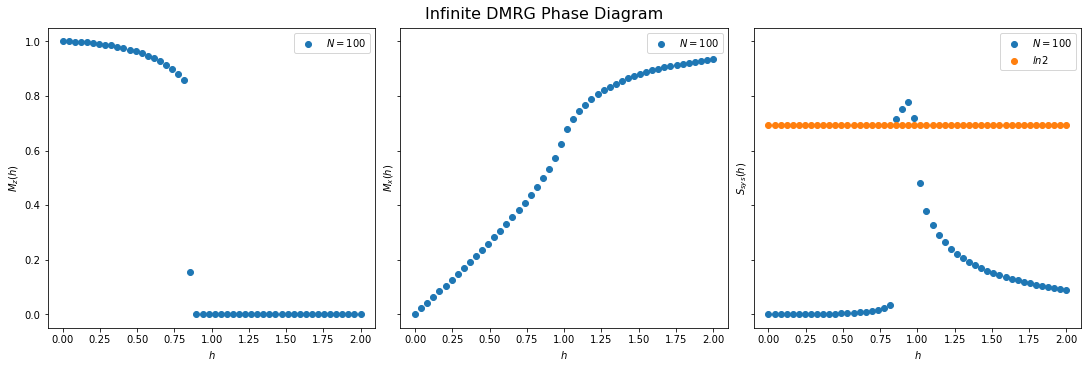

In [10]:
n = 100
fig, (fig_magz, fig_magx, fig_ent_s) = plt.subplots(1,3,figsize=(15, 5), constrained_layout=True, sharey=True)
fig_magz.scatter(h_arr,np.abs(magz_arr),label=r'$N= %d$'%n)
#fig_magz.set_title(r'M_(z)')
fig_magz.set_xlabel(r'$h$')
fig_magz.set_ylabel(r'$M_z(h)$')
fig_magz.legend()


fig_magx.scatter(h_arr,np.abs(magx_arr),label=r'$N= %d$'%n)
fig_magx.set_xlabel(r'$h$')
fig_magx.set_ylabel(r'$M_x(h)$')
#fig_magx.set_title('M_(x)')
fig_magx.legend()

fig_ent_s.scatter(h_arr,np.abs(ent_s_arr),label=r'$N= %d$'%n)
fig_ent_s.scatter(h_arr,np.log(2*np.ones(disc_point)),label=r'$ln2$')
fig_ent_s.set_xlabel(r'$h$')
fig_ent_s.set_ylabel(r'$S_{sys}(h)$')
#fig_magx.set_title('M_(x)')
fig_ent_s.legend()

fig.suptitle('Infinite DMRG Phase Diagram', fontsize=16)
#plt.savefig('Infinite DMRG Phase Diagram N=%d.png'%n, dpi=300, bbox_inches='tight')

In [11]:
def graphic(sys_block, env_block, sys_label="l"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

def infinite_system_algorithm(J,h,L, m):
    H1 = h*Sx1 + 1e-8*Sz1
    Magz1 = Sz1
    Magx1 = Sx1
    initial_block = SysBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        })
    block = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        #print("L =", block.length * 2 + 2)
        block, energy, expect_magz, expect_magx = single_dmrg_step(J,h,block, block, m=m)
    #print("E/L =", energy / (block.length * 2))
    print("Magz/L =", expect_magz / (block.length * 2))
    print("Magx/L =", expect_magx / (block.length * 2))
    #print("L =", block.length * 2)
    EXP_MAGZ = expect_magz / (block.length * 2)
    EXP_MAGX = expect_magx / (block.length * 2)
    return energy, EXP_MAGZ,EXP_MAGX

def finite_system_algorithm(J,h,L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    H1 = h*Sx1 + 1e-8*Sz1
    Magz1 = Sz1
    Magx1 = Sx1
    initial_block = SysBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        })
    block = initial_block
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        print(graphic(block, block))
        block, energy, expect_magz, expect_magx, ent_s = single_dmrg_step(J,h,block, block, m=m_warmup)
        print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            print(graphic(sys_block, env_block, sys_label))
            sys_block, energy, expect_magz, expect_magx, ent_s = single_dmrg_step(J,h,sys_block, env_block, m=m)

            print("E/L =", energy / L)
            print("MAGZ/L =", expect_magz[0] / L)
            print("MAGX/L =", expect_magx[0] / L)
            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop
    EXP_MAGZ = expect_magz[0] / L
    EXP_MAGX = expect_magx[0] / L
    return energy, EXP_MAGZ,EXP_MAGX
if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    #infinite_system_algorithm(L=100, m=20)
    #finite_system_algorithm(J=-1,h=-1,L=64, m_warmup=10, m_sweep_list=[10, 20, 30, 40, 40])

In [ ]:
disc_point = 100
h_arr = np.linspace(0,2,disc_point)
magz_arr = np.linspace(0,2,disc_point)
magx_arr = np.linspace(0,2,disc_point)
for i in range(disc_point):
    energy, EXP_MAGZ,EXP_MAGX = finite_system_algorithm(J=-1,h=h_arr[i],L=200, m_warmup=40, m_sweep_list=[10, 20, 30, 40, 40])
    magz_arr[i] =  EXP_MAGZ[0]
    magx_arr[i] =  EXP_MAGX[0]
    print("Magz =", EXP_MAGZ[0])
    print("Magx =", EXP_MAGX[0])

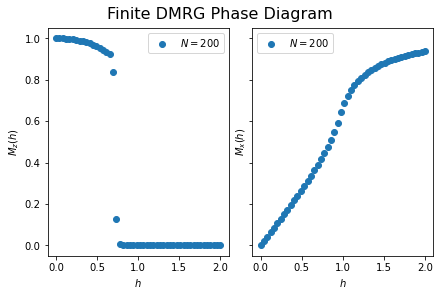

In [10]:
n = 200
fig, (fig_magz, fig_magx) = plt.subplots(1, 2, constrained_layout=True, sharey=True)
fig_magz.scatter(h_arr,np.abs(magz_arr),label=r'$N= %d$'%n)
#fig_magz.set_title(r'M_(z)')
fig_magz.set_xlabel(r'$h$')
fig_magz.set_ylabel(r'$M_z(h)$')
fig_magz.legend()


fig_magx.scatter(h_arr,np.abs(magx_arr),label=r'$N= %d$'%n)
fig_magx.set_xlabel(r'$h$')
fig_magx.set_ylabel(r'$M_x(h)$')
#fig_magx.set_title('M_(x)')
fig_magx.legend()


fig.suptitle('Finite DMRG Phase Diagram', fontsize=16)
plt.savefig('Finite DMRG Phase Diagram N=%d.png'%n, dpi=300, bbox_inches='tight')

In [12]:
finite_system_algorithm(J=-1,h=-1,L=10, m_warmup=10, m_sweep_list=[10, 20])

=**-
truncation error: 0
E/L = -1.1896926207859089
==**--
truncation error: 0.00019949229959995238
E/L = -1.2160383017597929
===**---
truncation error: 1.1746345662051955e-15
E/L = -1.2297439309324292
====**----
truncation error: 5.052068481284123e-14
E/L = -1.2381489999610165
=====**---
truncation error: 2.130025276137195e-14
E/L = -1.2381489999631978
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322551995]
======**--
truncation error: -4.108823822063216e-20
E/L = -1.2381489999631747
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322551995]
-------**=
truncation error: 0
E/L = -1.2381489999631754
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322551995]
------**==
truncation error: 0.0004679607627216827
E/L = -1.2381489999631738
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322551995]
-----**===


C:\Users\Qiancan-Chen\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


truncation error: 2.1300253858566633e-14
E/L = -1.238148999963197
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322551995]
----**====
truncation error: 5.064492303178547e-14
E/L = -1.238148999963224
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322551995]
---**=====
truncation error: 2.130167457920368e-14
E/L = -1.2381489999654038
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322550547]
--**======
truncation error: -3.955455324352764e-19
E/L = -1.2381489999653819
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322550547]
=**-------
truncation error: 0
E/L = -1.2381489999653816
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322550547]
==**------
truncation error: 0.0004679607649696131
E/L = -1.238148999965381
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322550547]
===**-----
truncation error: 2.130167925437688e-14
E/L = -1.2381489999654047
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322550547]
====**----
truncation error: 5.07696402887017e-14
E/L = -1.2381489999654323
MAGZ/L = [-0.000000038]
MAGX/L = [0.7322550547]
=====**---
truncation error: 0
E/

(-12.381489999654768, array([-0.000000038]), array([0.7322550547]))